In [2]:
!pip install einops

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: Loading egg at /global/common/software/nersc9/pytorch/2.3.1/lib/python3.11/site-packages/torchvision-0.18.0a0+6043bc2-py3.11-linux-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.2 MB/s eta 0:00:00


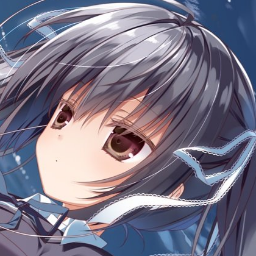

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.io import read_image, ImageReadMode
from torchvision.transforms.functional import to_pil_image

from tqdm import tqdm
from einops import rearrange

def viz_image(pt_img: torch.Tensor):
    pil_img = to_pil_image(pt_img)
    display(pil_img)

    
input_image = read_image('misuzu.png', ImageReadMode.RGB)
input_image = input_image.to(torch.float32) / 255
input_image = input_image.unsqueeze(0)
input_image = F.interpolate(input_image, (256, 256), mode='bilinear')
viz_image(input_image[0])

In [4]:
class MLP(nn.Module):
    def __init__(self, in_c, out_c=3, hiden_states=256):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Conv2d(in_c, hiden_states, 1), nn.ReLU(), nn.BatchNorm2d(hiden_states),
            nn.Conv2d(hiden_states, hiden_states, 1), nn.ReLU(), nn.BatchNorm2d(hiden_states),
            nn.Conv2d(hiden_states, hiden_states, 1), nn.ReLU(), nn.BatchNorm2d(hiden_states),
            nn.Conv2d(hiden_states, out_c, 1), nn.Sigmoid()
        )

    def forward(self, x):
        return self.mlp(x)

In [5]:
H, W = input_image.shape[2:]

h_coord = torch.linspace(0, 1, H)
w_coord = torch.linspace(0, 1, W)
grid = torch.stack(torch.meshgrid([h_coord, w_coord]), -1).permute(2, 0, 1).unsqueeze(0)

/global/common/software/nersc9/pytorch/2.3.1/lib/python3.11/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pscratch/sd/s/swowner/pytorch-build/pytorch/2.3.1/pytorch/aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


  0%|          | 0/400 [00:00<?, ?it/s]

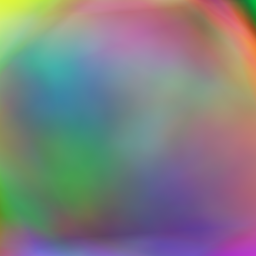

  8%|▊         | 32/400 [00:01<00:08, 41.24it/s]

0.22456911206245422


 25%|██▍       | 99/400 [00:01<00:02, 103.76it/s]

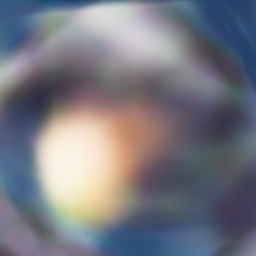

 34%|███▍      | 136/400 [00:01<00:02, 125.58it/s]

0.10835535824298859


 46%|████▋     | 186/400 [00:02<00:01, 144.08it/s]

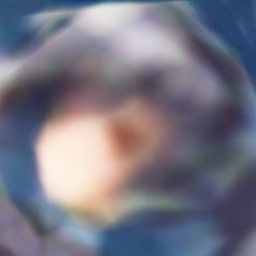

 58%|█████▊    | 233/400 [00:02<00:01, 157.77it/s]

0.09725405275821686


 72%|███████▏  | 287/400 [00:02<00:00, 148.06it/s]

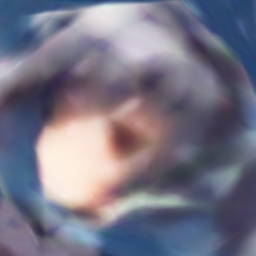

 83%|████████▎ | 333/400 [00:03<00:00, 154.23it/s]

0.08788691461086273


100%|█████████▉| 398/400 [00:03<00:00, 181.34it/s]

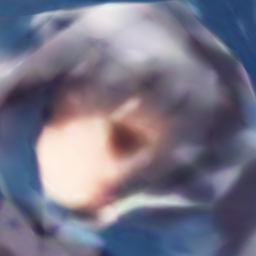

100%|██████████| 400/400 [00:03<00:00, 112.12it/s]

0.08293955028057098


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MLP(2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
n_loops = 400
input_image = input_image.to(device)
grid = grid.to(device)
for epoch in tqdm(range(n_loops)):
    output = model(grid)
    loss = F.l1_loss(output, input_image)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0 or epoch == n_loops - 1:
        viz_image(output[0])
        print(loss.item())

  0%|          | 0/400 [00:00<?, ?it/s]

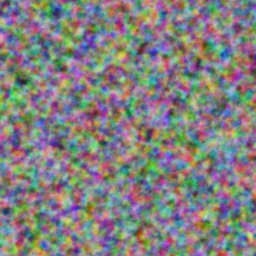

  6%|▌         | 23/400 [00:00<00:04, 92.64it/s]

0.2238924205303192


 23%|██▎       | 93/400 [00:00<00:01, 164.34it/s]

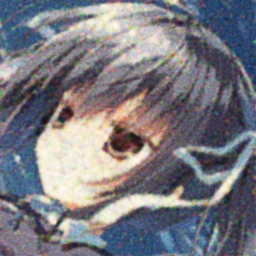

 35%|███▌      | 140/400 [00:00<00:01, 201.41it/s]

0.058598220348358154


 50%|████▉     | 198/400 [00:01<00:01, 151.92it/s]

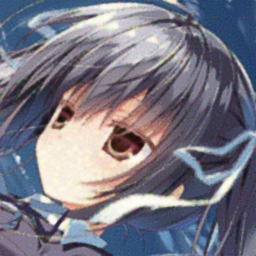

 57%|█████▋    | 229/400 [00:01<00:01, 139.85it/s]

0.03505769744515419


 75%|███████▌  | 300/400 [00:02<00:00, 131.41it/s]

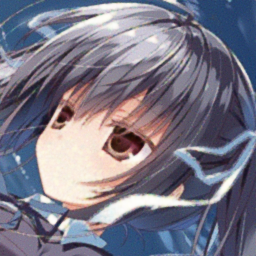

 82%|████████▏ | 329/400 [00:02<00:00, 130.35it/s]

0.0270452331751585


 99%|█████████▉| 397/400 [00:02<00:00, 128.66it/s]

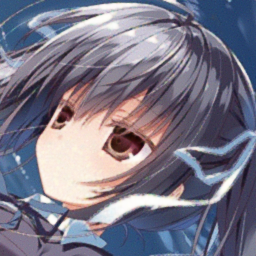

100%|██████████| 400/400 [00:03<00:00, 132.55it/s]

0.02310752496123314


In [7]:
class FourierFeature(nn.Module):
    def __init__(self, in_c, out_c, scale):
        super().__init__()
        fourier_basis = torch.randn(in_c, out_c // 2) * scale
        self.register_buffer('_fourier_basis', fourier_basis)
        
    def forward(self, x):
        N, C, H, W = x.shape
        x = rearrange(x, 'n c h w -> (n h w) c')
        x = x @ self._fourier_basis
        x = rearrange(x, '(n h w) c -> n c h w', h = H, w = W)
            
        x = 2 * torch.pi * x
        x = torch.cat([torch.sin(x), torch.cos(x)], dim=1) 
        return x
        
feature_length = 256
model = MLP(feature_length).to(device)
fourier_feature = FourierFeature(2, feature_length, 10).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
n_loops = 400
for epoch in tqdm(range(n_loops)):
    x = fourier_feature(grid)
    output = model(x)
    loss = F.l1_loss(output, input_image)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0 or epoch == n_loops - 1:
        viz_image(output[0])
        print(loss.item())
prev_output = output